## Load configuration

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
from src.utils.config_loader import load_config
cfg = load_config("../config.yaml")
data_cfg = cfg['data']
model_cfg = cfg['model']
training_cfg = cfg['training']

model_parameters = {
    'n':{'csp': [False, True], 'depth' : [1, 1, 1, 1, 1, 1], 'width' : [3, 16, 32, 64, 128, 256]},
    's':{'csp': [False, True], 'depth' : [1, 1, 1, 1, 1, 1], 'width' : [3, 32, 64, 128, 256, 512]},
    'm':{'csp': [True, True], 'depth' : [1, 1, 1, 1, 1, 1], 'width' : [3, 64, 128, 256, 512, 512]},
    'l':{'csp': [True, True], 'depth' : [2, 2, 2, 2, 2, 2], 'width' : [3, 64, 128, 256, 512, 512]},
    'x':{'csp': [True, True], 'depth' : [2, 2, 2, 2, 2, 2], 'width' : [3, 96, 192, 384, 768, 768]},
}

## Load Data Sample

In [3]:
from src.data.data_loader import get_data_loaders

In [4]:
train_loader, val_loader = get_data_loaders(
    os.path.join("../", data_cfg['processed_dir'], data_cfg['train_parquet']),
    os.path.join("../", data_cfg['processed_dir'], data_cfg['val_parquet']),
    "../" + data_cfg['train_images'],
    "../" + data_cfg['train_images'],
    training_cfg['batch_size'],
    is_test=True
)
print("Loaded train and validation data loaders")

[INFO] Loaded parquet file - ../dataset/processed/parquet/train
[INFO] Reducing data for test
[INFO] Loaded parquet file - ../dataset/processed/parquet/train
[INFO] Reducing data for test
[INFO] Creating Train Loader...

[INFO] Creating Val Loader...
Loaded train and validation data loaders


In [5]:
len(train_loader), len(val_loader)

(25, 25)

In [6]:
images, targets = next(iter(train_loader))
len(images), len(targets)

(4, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.4482791].


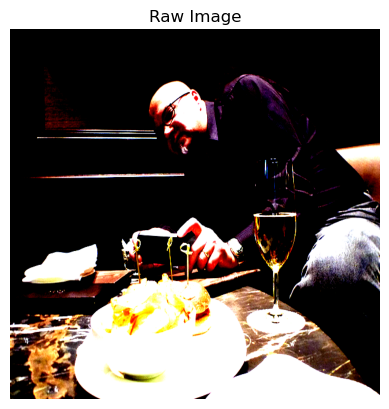

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.4482791].


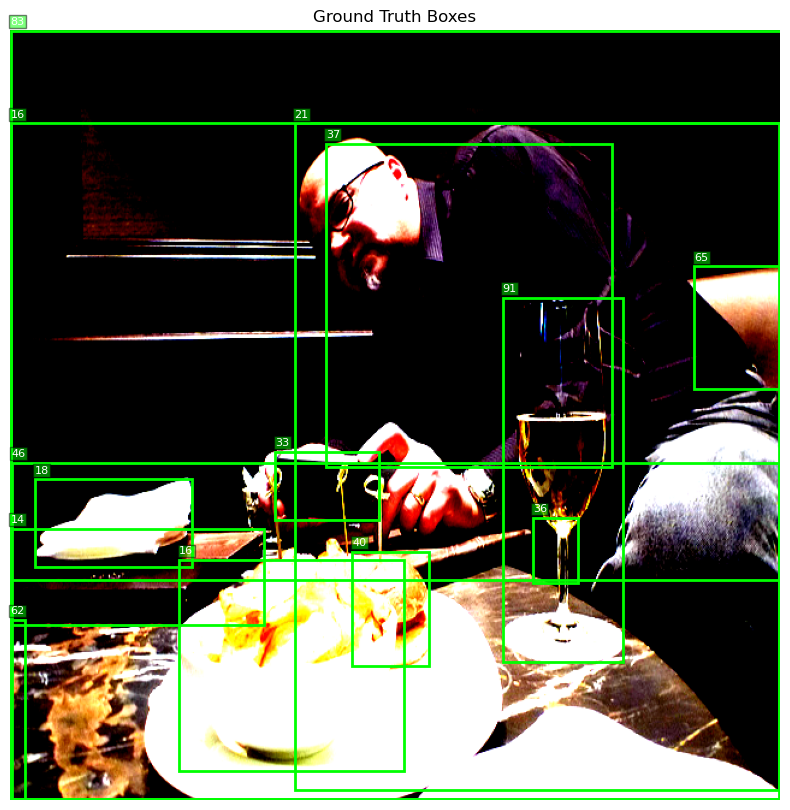

In [7]:
from src.data.visualization import visualize_comparison

visualize_comparison(images[0], targets[0])

## Training loop

In [8]:
import torch
from src.training.train_model import train
from src.model.losses import YoloDFLQFLoss
from src.training.utils_train import get_optimizer

In [9]:
device = 'cpu'

if torch.cuda.is_available():
    device = 'cuda'
# elif torch.mps.is_available():
#     device = 'mps'
print(f"Device - {device}")

Device - cuda


In [10]:
import torch
from src.model.model_builder import Model

model = Model(**model_parameters['m'], num_classes=model_cfg['num_classes']).to(device)

In [11]:
optimizer, scheduler = get_optimizer(
    model,
    training_cfg['learning_rate'],
    training_cfg['weight_decay'],
    training_cfg['learning_rate_patience'],
    training_cfg['learning_rate_factor']
)

In [12]:
criterion = YoloDFLQFLoss(
    num_classes=model_cfg['num_classes'],
    lambda_box=training_cfg.get('lambda_box', 1.5),
    lambda_cls=training_cfg.get('lambda_cls', 1.0)
)

In [13]:
from src.training.wandb_setup import setup_wandb

wandb_config = cfg["wandb"]
config = {
    # "gpu": world_size,
    **training_cfg
}
wandb_run = setup_wandb(config, wandb_config)

wandb: Currently logged in as: daryl99 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[INFO] WanDB Initialzed


In [14]:
train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    # num_epochs=training_cfg["epochs"],
    num_epochs=1,
    device=device,
    num_classes=model_cfg['num_classes'],
    rank=0,
    use_wandb=True if wandb_run else False,
    wandb_instance=wandb_run,
    log_interval=training_cfg.get('log_interval', 10),
    checkpoint_dir=os.path.join("..", training_cfg.get('checkpoint_dir', 'experiments/checkpoints')),
    iou_threshold=training_cfg.get('iou_threshold', 0.5),
    conf_threshold=training_cfg.get('conf_threshold', 0.25)
)

[Epoch 1/1] Validation: 100%|██████████| 25/25 [00:36<00:00,  1.48s/it, Loss=202.5142, Box=91.7091, Cls=64.9506]



Epoch 1/1 Summary:
  Train - Total: 395.6451 | Box: 223.5507 | Cls: 60.3190
  Val   - Total: 202.5142 | Box: 91.7091 | Cls: 64.9506
  Metrics - Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | mAP: 0.0000
  Detection - TP: 0 | FP: 10000 | FN: 1648
  LR: 0.000100



In [15]:
wandb_run.finish()

epoch,▁
lr,▁
step,▁▅█
train/box_loss,▆▁█
train/cls_loss,█▃▁
train/epoch_box_loss,▁
train/epoch_cls_loss,▁
train/epoch_loss,▁
train/total_loss,█▁▃
val/epoch_box_loss,▁
+6,...
